# Estimate the number for required samples

A key question to address before using an active learning loop is if the number of initialization samples is "sufficient". One heuristic to estimate this is to perform learning curve analysis. 

- The cross-validation error of the model trained with all initialization samples will indicate if the model has any predictive power
- The shape of the learning curve will indicate if the model is already saturated or if additional samples (e.g., acquired via the active learning) can increase the performance

One still has to note though that a model that is not predictive at intialization may become predictive at some point in the active learning process. This might be connected to the danger of underestimating uncertainties, for which reason we print a warning if the cross-validation error is greater than the variance. 

In [14]:
from pyepal import PALSklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import StandardScaler
from pyepal.models.gpr import build_coregionalized_model
from pyepal.pal.utils import exhaust_loop
from pyepal.plotting import plot_learning_curve
import numpy as np
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

We will use the [Binh-Korn test function](https://en.wikipedia.org/wiki/Test_functions_for_optimization), which defines our Pareto front.

In [15]:
def binh_korn(x, y):  # pylint:disable=invalid-name
    """https://en.wikipedia.org/wiki/Test_functions_for_optimization"""
    obj1 = 4 * x ** 2 + 4 * y ** 2
    obj2 = (x - 5) ** 2 + (y - 5) ** 2
    return -obj1, -obj2

In [16]:
def binh_korn_points():
    """Create a dataset based on the Binh-Korn test function"""
    x = np.linspace(0, 5, 100)  # pylint:disable=invalid-name
    y = np.linspace(0, 3, 100)  # pylint:disable=invalid-name
    array = np.array([binh_korn(xi, yi) for xi, yi in zip(x, y)])
    return np.hstack([x.reshape(-1, 1), y.reshape(-1, 1)]), array

In [17]:
x, points = binh_korn_points()

In [18]:
palinstance = PALSklearn(x, [GaussianProcessRegressor(RBF(length_scale=0.01, length_scale_bounds=(1e-03, 1e3)), alpha=0.01), 
            GaussianProcessRegressor(RBF(length_scale=0.01, length_scale_bounds=(1e-03, 1e3)), alpha=0.01)], 2)

To plot a learning curve we can use the `plot_learning_curve` function from the `pyepal.plotting` subpackage. This function takes a `PALBase` instance and the labels. You can optionally also provide the indices, the number of points on the learning curve, a `KFold` object, and a list of metrics. 

The function will output a plot of a learning curve and a dictionary with the metrics.

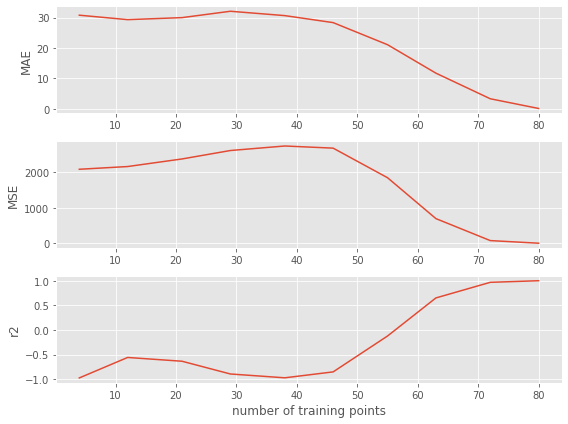

In [19]:
fig, metrics = plot_learning_curve(palinstance, points, num_steps=10)

Often, tuning some hyperparameters and scaling of the data can improve the performance.

In [20]:
palinstance_scaled = PALSklearn(StandardScaler().fit_transform(x), [GaussianProcessRegressor(RBF(length_scale=0.05, length_scale_bounds=(1e-02, 1e1)), alpha=0.00001, normalize_y=True), 
            GaussianProcessRegressor(RBF(length_scale=0.05, length_scale_bounds=(1e-02, 1e1)), alpha=0.00001, normalize_y=True)], 2)

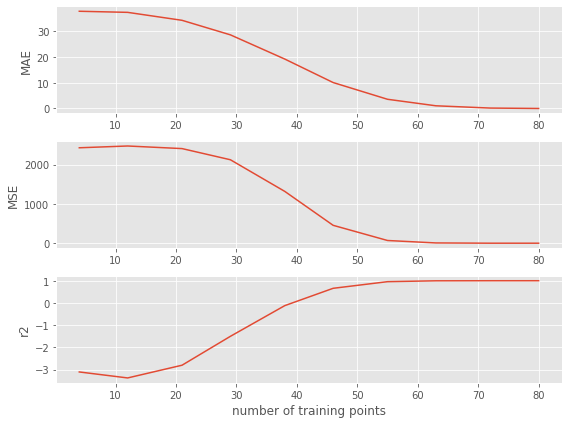

In [21]:
fig, metrics = plot_learning_curve(palinstance_scaled, points, num_steps=10)